# Assignment 3

#### Group 5

### Info:
    In the Python tutorial(covered on 6-Mar-2021), we created several customer attributes(features) that were then used to develop a binary classification model(using Logistic Regression) to predict the probability that a customer will make at least one purchase (order) within the next month. For this assignment, use Jan through July 2018(1-1-2018 to 7-31-2018) as the prediction window, and complete the following tasks:

### Import Packages

In [1]:
# data processing
import numpy as np
import pandas as pd
from datetime import date

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

### Data Setup

In [2]:
# full path of the orders dataset
orders_file = '../data/olist_orders_dataset.csv'

# full path of the customer dataset
cust_file = '../data/olist_customers_dataset.csv'

### Read Data

In [3]:
def read_olist_data(file1, file2, use_cols, cutoff_dt, verbose):
    
    # read the orders data
    orders = pd.read_csv(file1)

    if verbose:
        print (f'{len(orders):,} read from the orders file.')

    # date-time conversion
    orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

    # let's convert the order purchase timestamps into dates
    orders['order_purchase_date'] = orders['order_purchase_timestamp'].dt.date

    # extract DOW from the order date
    orders['order_dow'] = orders['order_purchase_timestamp'].dt.day_name()
    
    # extract month name from the order date
    orders['order_month'] = orders['order_purchase_timestamp'].dt.month_name()
    

    # read the file that contains the unique customer identifier
    # also, let's keep only the following two columns: customer_id, customer_unique_id
    cust = pd.read_csv(file2, usecols=['customer_id', 'customer_unique_id', 'customer_state'])
    
    if verbose:
        print (f'{len(cust):,} read from the customer file.')

    # merge orders and cust dataframes
    orders_out = pd.merge(orders, cust, on='customer_id', how='inner')
    
    # discard (incomplete) data after cutoff_dt
    # we do this here by using a boolean (True/False) mask
    mask = orders_out['order_purchase_date'] <= cutoff_dt

    orders_out = orders_out[mask]
    
    # sort the output dataset by order date for each customer
    orders_out = orders_out[use_cols].sort_values(['customer_unique_id', 'order_purchase_timestamp'])

    if verbose:
        print (f'{len(orders_out):,} records in the output  file.')
    
    return orders_out

In [4]:
# we will keep only these columns for this exercise
use_cols = ['customer_unique_id', 'order_id', 'order_purchase_timestamp', 'order_dow', 'order_month', 'order_status', 'customer_state','order_purchase_date']

# we will discard (incomplete) data after 8/22/18 (see 06_pandas_wrangle.ipynb for the rationale)
cutoff_date = date(2018, 7, 31)

orders = read_olist_data(orders_file, cust_file, use_cols, cutoff_date, 1)

99,441 read from the orders file.
99,441 read from the customer file.
92,909 records in the output  file.


In [5]:
orders.head()

,customer_unique_id,order_id,order_purchase_timestamp,order_dow,order_month,order_status,customer_state,order_purchase_date
52798,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10 10:56:27,Thursday,May,delivered,SP,2018-05-10
73889,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-07 11:11:27,Monday,May,delivered,SP,2018-05-07
26460,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03,Friday,March,delivered,SC,2017-03-10
98493,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:29:41,Thursday,October,delivered,PA,2017-10-12
41564,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-14 19:45:42,Tuesday,November,delivered,SP,2017-11-14


### 1. Recreate all customer attributes that we created in the tutorial.(Hint: Use the observation window prior to Jan 2018.)

In [6]:
# limit data to before prediction window
snapshot_date = date(2017, 12, 31)
mask = orders['order_purchase_timestamp'].dt.date <= snapshot_date
df_raw = orders[mask]
df_raw.order_purchase_timestamp.max()

Timestamp('2017-12-31 23:29:31')

#### Old Attribute 1: Order recency

In [7]:
# grab the max purchase date for each customer
cust_recency = df_raw.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()

# count the number of days between the most recent order date and the snapshot date
delta = snapshot_date - cust_recency['order_purchase_timestamp'].dt.date

# grab the number of days (as an integer) from the calculated deltas 
cust_recency['order_recency'] = delta.dt.days / 30
cust_recency['order_recency'] = cust_recency['order_recency'].astype(int)

# drop the date (we don't need it any more for this exercise)
cust_recency = cust_recency.drop('order_purchase_timestamp', axis=1)

#### Old Attribute 2: Number of orders per customer

In [8]:
# count total records (i.e., orders) per customer
cust_orders = df_raw.groupby('customer_unique_id').size().reset_index().rename(columns={0: 'total_orders'})


#### Old Attribute 3: Weekday

In [9]:
# get dummies
df_raw = pd.get_dummies(df_raw, columns=['order_dow'])

# grab all binary columns that we just created
dummies = [x for x in df_raw.columns if 'order_dow_' in x]

# aggreagte data to the customer-level, so that we have one record per customer
cust_dow = df_raw.groupby('customer_unique_id')[dummies].sum().reset_index()

In [10]:
cust_recency.shape, cust_orders.shape, cust_dow.shape

((44034, 2), (44034, 2), (44034, 8))

### 2. Create three additional attributes of your choice derived from the data available in the two files.

Ideas: how often they purchase or average days between purchases (purchase frequency), total orders not delivered, order month, customer state

#### New Attribute 1: Total orders not delivered

In [11]:
# change order status to 1 or 0 for delivered or not, 1 for not delivered since thats what we are counting

df_raw.loc[df_raw['order_status'] == 'delivered', 'order_status1'] = 0
df_raw.loc[df_raw['order_status'] != 'delivered', 'order_status1'] = 1

In [12]:
# count number of undelivered orders

not_delv = df_raw.groupby('customer_unique_id')['order_status1'].sum().reset_index().rename(columns={'order_status1': 'total_not_delv'})

In [13]:
not_delv.shape

(44034, 2)

#### New Attribute 2: Order month

In [14]:
# get dummies
df_raw = pd.get_dummies(df_raw, columns=['order_month'])

# grab all binary columns that we just created
dummies1 = [x for x in df_raw.columns if 'order_month_' in x]

# aggreagte data to the customer-level, so that we have one record per customer
cust_month = df_raw.groupby('customer_unique_id')[dummies1].sum().reset_index()

In [15]:
cust_month.shape

(44034, 13)

#### New Attribute 3: Avg Orders Per Month

In [16]:
avg_monthly_orders = df_raw.groupby('customer_unique_id').size().reset_index().rename(columns={0: 'total_orders'})

In [17]:
# calculate roughly the number of months in the timeframe

time_delta = df_raw['order_purchase_timestamp'].min() - df_raw['order_purchase_timestamp'].max()
time_delta = round(abs(time_delta.days) / 30,0)

time_delta

16.0

In [18]:
# divide total orders by number of months for avg orders per month

avg_monthly_orders = df_raw.groupby('customer_unique_id').size().reset_index().rename(columns={0: 'total_orders'})

In [19]:
avg_monthly_orders['avg_orders'] = avg_monthly_orders['total_orders'] / time_delta

In [20]:
avg_monthly_orders =  avg_monthly_orders.drop(['total_orders'], axis = 1)

In [21]:
avg_monthly_orders.shape

(44034, 2)

In [22]:
# merge attributes
df = pd.merge(cust_recency, cust_orders, on='customer_unique_id').merge(cust_dow, on='customer_unique_id')\
.merge(not_delv, on='customer_unique_id').merge(cust_month, on='customer_unique_id').merge(avg_monthly_orders, on='customer_unique_id')

# remove customers with no orders in the last year
df = df[df['order_recency'] <= 12]

### 3. Create the dependent variable, purch, using the following definition: did the customer make at least one purchase during the prediction window? If a customer didmake a purchase within the prediction window, then set purch to 1, otherwise set it to 0. (This is the same definition that we used in the class, except for the length of the prediction window.)

**Step 1:** Isolate all orders that were placed within the prediction window.

In [23]:
# select orders that were placed in July 2018

mask = orders['order_purchase_timestamp'].dt.date > snapshot_date

target_events_raw = orders[mask]

In [24]:
print (target_events_raw['order_purchase_timestamp'].min(), target_events_raw['order_purchase_timestamp'].max())

2018-01-01 02:48:41 2018-07-31 23:54:20


**Step 2:** Summarize data to get one record per customer.

In [25]:
# count the number of orders (we will convert this into a binary flag later)

target_events = target_events_raw.groupby('customer_unique_id').size().reset_index().rename(columns={0: 'purch'})

**Step 3:** Merge this dataframe with the `attr` dataframe to create the modeling dataset.

In [26]:
# merge `target_events` with the dataframe that contains customer attributes

df = pd.merge(df, target_events, how='left', on='customer_unique_id')

**Step 4:** Set the target variable to 1 if at least one purchase was made, 0 otherwise.

In [27]:
# create the binary target flag

df['purch'] = [1 if x > 0 else 0 for x in df['purch']]

### 4. Split the modeling set into two equal partitions: ‘train’and ‘test’.Use the ‘train’ set for tasks #5 and #6 below.

In [28]:
preds = df.columns[1:-1]

X = df[preds]
y = df['purch']

In [29]:
# split the dataframe into train(50%) and test(50%)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=314)

len(X_train), len(X_test)

(21856, 21857)

### 5. Build a Logistic Regression model using purch as the target(dependent) variable and include all attributes created in tasks #1 and #2 above as model features.

In [30]:
from sklearn.linear_model import LogisticRegression

# define the model object ('liblinear' is recommended for small datasets)
clf = LogisticRegression(solver='liblinear', random_state=314)

# train (fit) the model using the training sample
clf.fit(X_train, y_train)

# make predictions on the test sample
y_preds = clf.predict(X_test)

#### Using the class weight method since the model predicted everything to be 0

In [31]:
clf1 = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=314)

clf1.fit(X_train, y_train)

y_preds1 = clf1.predict(X_test)

### 6. Build one more classification model using Decision Tree.

In [51]:
from sklearn.tree import DecisionTreeClassifier

from sklearn import tree

dtree = DecisionTreeClassifier(max_depth=5,random_state=314, class_weight = 'balanced')

dtree_orders = dtree.fit(X_train, y_train)

tree_preds = dtree_orders.predict(X_test)

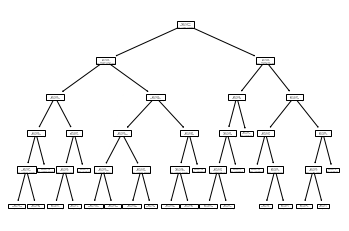

In [52]:
tree.plot_tree(dtree_orders);

### 7.Using the ‘test’ partition(created in task #4), to compare the performance of the two models (created in tasks #6 and #7 above) using the following metrics:
    a.AUC (Area Under the ROC Curve), and
    
    b.Confusion matrix, 
    
    Find the Pearson correlation coefficient between the predicted probabilities (for the entire dataset) from the two models.
    
    Which model (if any) would you recommendbased on these model validation results?

**A.** AUC

Logistic Regression Model 0:

In [53]:
# Logistic Regression accuracy
from sklearn.metrics import roc_auc_score

# calculate the probabilities on the test sample
y_scores = clf.predict_proba(X_test)[:, 1]

# calcualte AUC for model 0
roc_auc_score(y_test, y_scores)

0.5351894238524981

Logistic Regression Model 1:

In [54]:
# calcualte AUC for model 0
y_scores1 = clf1.predict_proba(X_test)[:, 1]

roc_auc_score(y_test, y_scores1)

0.5357132199028422

In [55]:
roc_auc_score(y_test, y_scores)

0.5351894238524981

Decision Tree:

In [56]:
y_scores_t = dtree.predict_proba(X_test)[:, 1]

roc_auc_score(y_test, y_scores_t)

0.5112345877129637

**B.** Confusion Matrix

Logistic Regression Model 0:

In [57]:
pd.crosstab(y_test, y_preds)

col_0,0,1
purch,,
0,21527,0
1,329,1


Logistic Regression Model 0:

In [58]:
pd.crosstab(y_test, y_preds1)

col_0,0,1
purch,,
0,14280,7247
1,200,130


Decision Tree:

In [59]:
pd.crosstab(y_test, tree_preds)

col_0,0,1
purch,,
0,16746,4781
1,249,81


**Correlation**

In [60]:
# find predictions on entire dataset
df['log_preds'] = clf1.predict(X)
df['tree_preds'] = dtree_orders.predict(X)

df.corr()['log_preds']

order_recency           -0.322114
total_orders             0.224465
order_dow_Friday        -0.228689
order_dow_Monday        -0.046389
order_dow_Saturday      -0.089809
order_dow_Sunday         0.361071
order_dow_Thursday       0.196899
order_dow_Tuesday       -0.010473
order_dow_Wednesday     -0.035930
total_not_delv           0.223690
order_month_April       -0.138611
order_month_August      -0.017702
order_month_December     0.412009
order_month_February     0.070532
order_month_January      0.013290
order_month_July        -0.160272
order_month_June        -0.093244
order_month_March       -0.136529
order_month_May         -0.077023
order_month_November    -0.014807
order_month_October     -0.083646
order_month_September    0.280502
avg_orders               0.224465
purch                    0.018781
log_preds                1.000000
tree_preds               0.514857
Name: log_preds, dtype: float64

In [61]:
df.corr()['tree_preds']

order_recency           -0.319476
total_orders             0.086837
order_dow_Friday        -0.013722
order_dow_Monday        -0.082965
order_dow_Saturday      -0.049534
order_dow_Sunday         0.610002
order_dow_Thursday      -0.086443
order_dow_Tuesday       -0.080375
order_dow_Wednesday     -0.202779
total_not_delv          -0.015106
order_month_April       -0.118398
order_month_August      -0.087099
order_month_December     0.532314
order_month_February    -0.046481
order_month_January     -0.037025
order_month_July        -0.071138
order_month_June        -0.057624
order_month_March       -0.068891
order_month_May         -0.066055
order_month_November    -0.073226
order_month_October     -0.031379
order_month_September    0.047740
avg_orders               0.086837
purch                    0.023083
log_preds                0.514857
tree_preds               1.000000
Name: tree_preds, dtype: float64

The logistic regression model 1, which used the balanced weight approach, seems to perform the best based on the AUC scores and the fact that the correlations of the variables are higher.

### 8. Perform k-fold cross-validation using sklearn.model_selection.cross_validate(). Picknumber of folds(k) of your choice.

In [49]:
from sklearn.model_selection import cross_validate

clf2 = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=314)

cv_results = cross_validate(clf2, X, y, cv=4)

mean_results = np.mean(cv_results['test_score'])

print(f"The mean of the model's results is: {mean_results:.2f}")

The mean of the model's results is: 0.60
